In [2]:
import os
import numpy as np
from skimage import io

import matplotlib.pyplot as plt
%matplotlib inline

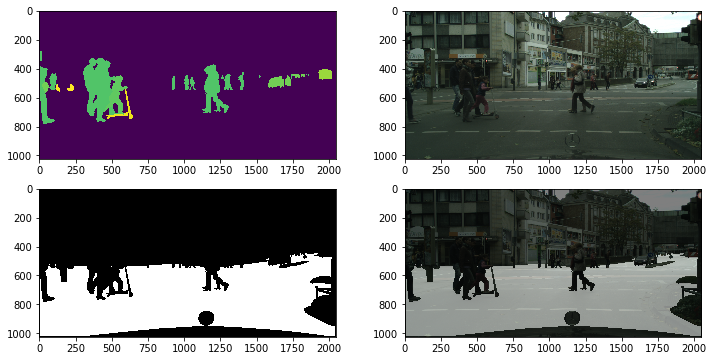

In [20]:
plt.figure(figsize=(12,6))

img1 = io.imread('gtFine/train/aachen/aachen_000014_000019_gtFine_instanceIds.png')
img2 = io.imread('leftImg8bit/train/aachen/aachen_000014_000019_leftImg8bit.png')
img3 = io.imread('gtFine/train/aachen/aachen_000014_000019_gtFine_instanceIds.png').astype(np.int8)


plt.subplot(221)
plt.imshow(img1)

plt.subplot(222)
plt.imshow(img2)

plt.subplot(223)
plt.imshow(np.logical_or(img3 == 7,img3 == 8), 'gray')

plt.subplot(224)
result = 0.5 * np.repeat(np.logical_or(img3 == 7,img3 == 8).reshape(img3.shape[0],img3.shape[1],1), 3, axis=2) + \
        0.5 * img2.astype(np.float32) / 255
plt.imshow(result)

In [24]:
trX = []
teX = []

trY = []
teY = []

for p in os.listdir('leftImg8bit/train'):
    print os.path.join('leftImg8bit/train',p)
    
    for f in os.listdir(os.path.join('leftImg8bit/train',p)):
        img_file = os.path.join('leftImg8bit/train',p,f)
        trX.append(io.imread(img_file)[::8,::8,:].astype(np.uint8))
        
        img_str_splt = img_file.split('leftImg8bit')
        gt_str = 'gtFine' + img_str_splt[1] + 'gtFine_instanceIds' + img_str_splt[2]
        img = io.imread(gt_str)
        trY.append((np.logical_or(img == 7, img == 8)[::8,::8]).astype(np.uint8))

# for p in os.listdir('leftImg8bit/test'):
#     print os.path.join('leftImg8bit/test',p)
    
#     for f in os.listdir(os.path.join('leftImg8bit/test',p))[::3]:
#         img_file = os.path.join('leftImg8bit/test',p,f)
#         teX.append(plt.imread(img_file)[::8,::8,:])

trX = np.array(trX)
teX = np.array(teX)

trY = np.array(trY)
teY = np.array(teY)

leftImg8bit/train/tubingen
leftImg8bit/train/zurich
leftImg8bit/train/hamburg
leftImg8bit/train/ulm
leftImg8bit/train/bremen
leftImg8bit/train/monchengladbach
leftImg8bit/train/bochum
leftImg8bit/train/hanover
leftImg8bit/train/erfurt
leftImg8bit/train/weimar
leftImg8bit/train/jena
leftImg8bit/train/strasbourg
leftImg8bit/train/aachen
leftImg8bit/train/stuttgart
leftImg8bit/train/krefeld
leftImg8bit/train/cologne
leftImg8bit/train/dusseldorf
leftImg8bit/train/darmstadt


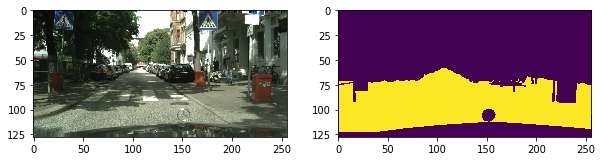

In [25]:
K = 401

plt.figure(figsize = (10,4))
plt.subplot(121)
plt.imshow(trX[K])

plt.subplot(122)
plt.imshow(trY[K].astype(np.float32))

In [76]:
import theano
import theano.tensor as T

import lasagne
from lasagne.updates import adam, total_norm_constraint
from lasagne.objectives import squared_error, binary_crossentropy
from lasagne.layers import DenseLayer, InputLayer, ConcatLayer, Conv2DLayer, MaxPool2DLayer, DilatedConv2DLayer, \
                           Pool2DLayer, Upscale2DLayer, PadLayer, ElemwiseSumLayer, ConcatLayer, SpatialPyramidPoolingLayer, \
                           LocallyConnected2DLayer, TransposedConv2DLayer, ReshapeLayer, \
                           FlattenLayer, DimshuffleLayer, NonlinearityLayer, \
                           BatchNormLayer, batch_norm, DropoutLayer, GaussianNoiseLayer, \
                           get_output, get_all_params, get_all_param_values, set_all_param_values
from lasagne.nonlinearities import rectify, sigmoid, softmax, tanh, linear

In [99]:
def output_layer_nonlinearity(x):
    return T.clip(sigmoid(x),1e-5,1.0-1e-4)


def network(image, p):
    input_image = InputLayer(input_var = image,
                             shape     = (None, 128, 256, 3))

    input_image = DimshuffleLayer(input_image,
                                  pattern = (0,3,1,2))
    
    conv1        = batch_norm(Conv2DLayer(input_image,
                                          num_filters  = 16,
                                          filter_size  = (3,3),
                                          stride       = (1,1),
                                          nonlinearity = rectify,
                                          pad          = 'same'))
    
    conv1        = batch_norm(Conv2DLayer(conv1,
                                          num_filters  = 16,
                                          filter_size  = (3,3),
                                          stride       = (1,1),
                                          nonlinearity = rectify,
                                          pad          = 'same'))
    
    conv1        = DropoutLayer(conv1, p=p)
    
    conv1        = ConcatLayer([input_image,
                                conv1], axis = 1)
    
    conv2        = batch_norm(Conv2DLayer(conv1,
                                          num_filters  = 32,
                                          filter_size  = (3,3),
                                          stride       = (1,1),
                                          nonlinearity = rectify,
                                          pad          = 'same'))
    
    conv2        = batch_norm(Conv2DLayer(conv2,
                                          num_filters  = 32,
                                          filter_size  = (3,3),
                                          stride       = (1,1),
                                          nonlinearity = rectify,
                                          pad          = 'same'))
    
    conv2        = DropoutLayer(conv2, p=p)
    
    conv2        = ConcatLayer([conv2,
                                conv1], axis = 1)
    
    atr1         = DilatedConv2DLayer(PadLayer(conv2, width = 1), 
                                      num_filters  = 16,
                                      filter_size  = (3,3), 
                                      dilation     = (1,1), 
                                      pad          = 0, 
                                      nonlinearity = rectify)
    
    atr2         = DilatedConv2DLayer(PadLayer(conv2, width = 2), 
                                      num_filters  = 16,
                                      filter_size  = (3,3), 
                                      dilation     = (2,2), 
                                      pad          = 0, 
                                      nonlinearity = rectify)
    
    atr4         = Upscale2DLayer(DilatedConv2DLayer(PadLayer(MaxPool2DLayer(conv2,
                                                                             pool_size = (2,2),
                                                                             stride    = (2,2),
                                                                             pad       = 0), width = 2), 
                                                     num_filters  = 16,
                                                     filter_size  = (3,3), 
                                                     dilation     = (2,2), 
                                                     pad          = 0, 
                                                     nonlinearity = rectify), scale_factor = 2)
    
    atr8         = Upscale2DLayer(DilatedConv2DLayer(PadLayer(MaxPool2DLayer(conv2,
                                                                             pool_size = (4,4),
                                                                             stride    = (4,4),
                                                                             pad       = 0), width = 2), 
                                                     num_filters  = 16,
                                                     filter_size  = (3,3), 
                                                     dilation     = (2,2), 
                                                     pad          = 0, 
                                                     nonlinearity = rectify), scale_factor = 4)
    
    sumblock    = ConcatLayer([conv2,
                               atr1,
                               atr2,
                               atr4,
                               atr8], axis = 1)
    
    ground      = Conv2DLayer(sumblock,
                              num_filters  = 1,
                              filter_size  = (3,3),
                              stride       = (1,1),
                              nonlinearity = output_layer_nonlinearity, 
                              pad          = 'same')

    ground        = ReshapeLayer(ground,
                                 shape = ([0],128,256))

    return ground

In [100]:
X  = T.ftensor4()
Y  = T.ftensor3()
P  = T.scalar()
lr = T.scalar()

RoadSegment = network(X,P)
rs          = get_output(RoadSegment)
frs         = get_output(RoadSegment, deterministic=True)

def load_weights():
    model_name = 'model_weights.npz'
    with np.load(model_name) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    set_all_param_values([RoadSegment], param_values)
    
def save_weights():
    np.savez('model_weights.npz', *get_all_param_values([RoadSegment])) 

road_segment  = theano.function(inputs               = [X],
                                outputs              = frs,
                                allow_input_downcast = True)


loss = binary_crossentropy(rs,Y)
loss = loss.mean()

IoU = T.and_(T.ge(rs, 0.5),T.ge(Y,0.5)).sum(axis=(1,2)) * \
      T.minimum(T.inv(T.or_(T.ge(rs, 0.5),T.ge(Y,0.5)).sum(axis=(1,2))), 120.0 * 160.0)
IoU = IoU.mean()

loss_function = theano.function(inputs               = [X,Y,P],
                                outputs              = [loss,IoU],
                                allow_input_downcast = True)

params = get_all_params(RoadSegment, trainable=True)

updates = adam(loss,
               params,
               learning_rate = lr)

train_network = theano.function(inputs               = [X,Y,P,lr],
                                outputs              = [loss,IoU],
                                updates              = updates,
                                allow_input_downcast = True)

In [ ]:
import time

print_episode = 2

n_epochs   = 100
batch_size = 32

p_min   = 0.02
p_max   = 0.1
p_decay = 0.8 * n_epochs

lr_max   = 0.025
lr_min   = 0.001
lr_gamma = 0.99

for epoch in range(n_epochs):
    p_noise = max(p_max - (p_max - p_min) * epoch / p_decay, p_min)
    learning_rate = max(lr_max * lr_gamma ** epoch, lr_min)
    
    epoch_err = []
    
    t0 = time.time()

    for start_id in range(0, len(trX), batch_size):
        t1 = time.time()
        
        err, iou = train_network(trX[start_id:start_id+batch_size], 
                                 trY[start_id:start_id+batch_size],
                                 p_noise,
                                 learning_rate)
        
        epoch_err.append([err, iou])
        
        t2 = time.time()
        
        save_weights()
        
        print 'epoch: %d, train_time: %f, error: %f, IoU: %f' % (epoch, t2 - t1, err, iou) + '\r',
    
    t3 = time.time()
    
    errs = np.mean(epoch_err, axis=0)
    print 'epoch: %d, error: %f, IoU: %f' % (epoch, errs[0], errs[1]) + '\r',

In [ ]:
plt.imshow(trX[10])

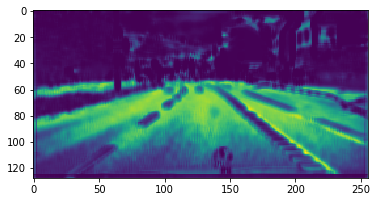

In [39]:
plt.imshow(road_segment(trX[10].astype(float).reshape(1,128,256,3)).reshape(128,256))

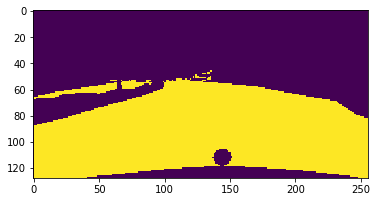

In [14]:
plt.imshow(trY[10])